In [1]:
import cv2
import numpy as np
import tensorflow as tf
import pyautogui
from PIL import Image

In [2]:
carpeta = "../plantvillage_dataset/grayscale/"

In [3]:
screen_width, screen_height = 400, 400

In [18]:
while True:
    # Capturar la pantalla
    screenshot = pyautogui.screenshot(region=(200, 300, screen_width, screen_height))
    screenshot = np.array(screenshot)  # Convertir a un array de NumPy
    # screenshot = cv2.cvtColor(screenshot, cv2.COLOR_RGB2GRAY)
    # screenshot = cv2.equalizeHist(screenshot, dst=None)
    # screenshot = cv2.cvtColor(screenshot, cv2.COLOR_RGB2BGR)  # Convertir a BGR (OpenCV usa BGR por defecto)
    screenshot = cv2.cvtColor(screenshot, cv2.COLOR_RGB2HSV)


    lower_green = np.array([35, 50, 50])  # Tono mínimo, saturación mínima, valor mínimo
    upper_green = np.array([85, 255, 255])  # Tono máximo, saturación máxima, valor máximo

    lower_brown = np.array([5, 50, 50])  # Tono mínimo, saturación mínima, valor mínimo
    upper_brown = np.array([25, 255, 255])  # Tono máximo, saturación máxima, valor máximo

    # Crear máscaras para verde y marrón
    mask_green = cv2.inRange(screenshot, lower_green, upper_green)
    mask_brown = cv2.inRange(screenshot, lower_brown, upper_brown)
    screenshot[:, :, 1] = np.where(mask_green > 0, 255, screenshot[:, :, 1])  # Aumentar saturación para verde
    screenshot[:, :, 1] = np.where(mask_brown > 0, 255, screenshot[:, :, 1])  # Aumentar saturación para marrón

    # Convertir de vuelta a BGR
    enhanced_image = cv2.cvtColor(screenshot, cv2.COLOR_HSV2BGR)

    # Mostrar la imagen en una ventana
    cv2.imshow("Detección en tiempo real", screenshot)

    # Salir del bucle si se presiona la tecla 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Cerrar la ventana
cv2.destroyAllWindows()

In [20]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Configurar rutas y parámetros
dataset_path = carpeta  # Cambia esto a la ruta de tu dataset
target_size = (256, 256)  # Redimensionar a 128x128
batch_size = 32
epochs = 10

# 2. Preprocesamiento y aumento de datos
datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalización de píxeles
    rotation_range=20,  # Rotación aleatoria
    width_shift_range=0.2,  # Desplazamiento horizontal aleatorio
    height_shift_range=0.2,  # Desplazamiento vertical aleatorio
    horizontal_flip=True,  # Volteo horizontal aleatorio
    validation_split=0.2  # 20% de los datos para validación
)

# 3. Cargar las imágenes de las 3 clases
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=target_size,
    color_mode='grayscale',  # Cargar en escala de grises
    batch_size=batch_size,
    class_mode='categorical',  # Clasificación multiclase
    classes=['Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Septoria_leaf_spot'],  # Tres clases
    subset='training'  # Conjunto de entrenamiento
)

validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=target_size,
    color_mode='grayscale',  # Cargar en escala de grises
    batch_size=batch_size,
    class_mode='categorical',  # Clasificación multiclase
    classes=['Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Septoria_leaf_spot'],  # Tres clases
    subset='validation'  # Conjunto de validación
)

# 4. Construir el modelo
model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')  # Capa de salida para 3 clases
])

# 5. Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Pérdida para clasificación multiclase
              metrics=['accuracy'])

# 6. Resumen del modelo
model.summary()

# 7. Entrenar el modelo
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs
)

# 8. Evaluar el modelo
loss, accuracy = model.evaluate(validation_generator)
print(f"Pérdida en validación: {loss}")
print(f"Precisión en validación: {accuracy}")

# 9. Guardar el modelo
model.save("modelo_tomate_3_clases.keras")

Found 4218 images belonging to 3 classes.
Found 1053 images belonging to 3 classes.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,838,787 (56.61 MB)

 Trainable params: 14,838,787 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 68s 513ms/step - accuracy: 0.4287 - loss: 1.2097 - val_accuracy: 0.7480 - val_loss: 0.6667
Epoch 2/10
  1/131 ━━━━━━━━━━━━━━━━━━━━ 59s 461ms/step - accuracy: 0.5625 - loss: 0.8953

c:\Users\aasal\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5625 - loss: 0.8953 - val_accuracy: 0.7773 - val_loss: 0.6032
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 60s 461ms/step - accuracy: 0.7380 - loss: 0.5873 - val_accuracy: 0.7354 - val_loss: 0.5449
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.6562 - loss: 0.7974 - val_accuracy: 0.7998 - val_loss: 0.4514
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 60s 460ms/step - accuracy: 0.7559 - loss: 0.5792 - val_accuracy: 0.8066 - val_loss: 0.4741
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.8125 - loss: 0.5368 - val_accuracy: 0.7578 - val_loss: 0.5453
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 62s 474ms/step - accuracy: 0.7827 - loss: 0.5096 - val_accuracy: 0.7920 - val_loss: 0.4837
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.8125 - loss: 0.3446 - val_accuracy: 0.7871 - val_loss: 0.4910
Epoch 9/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 64s 486ms/step - accuracy: 0.8263 - loss: 0.4190 - val_accurac

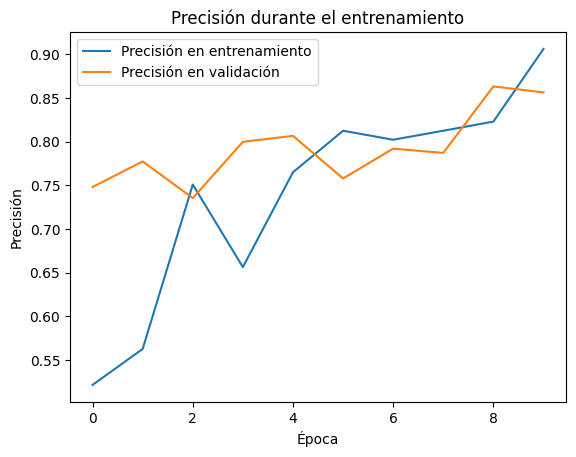

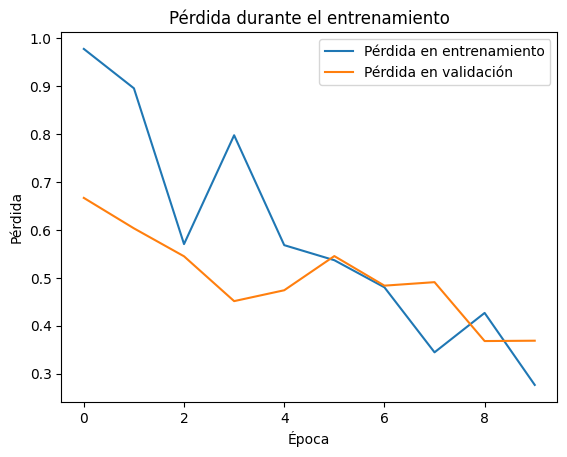

In [6]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Gráfico de pérdida
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [8]:
import cv2
import numpy as np
import tensorflow as tf
import pyautogui
from PIL import Image

# 1. Cargar el modelo entrenado
model = tf.keras.models.load_model("modelo_tomate_3_clases.keras")

# 2. Definir el tamaño de la región de la pantalla a capturar
screen_width, screen_height = 400, 400  # Resolución

def preprocess_image(image):
    # Convertir a escala de grises
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Redimensionar a 128x128 (tamaño esperado por el modelo)
    resized_image = cv2.resize(gray_image, (256, 256))
    # Normalizar los valores de píxeles
    normalized_image = resized_image / 255.0
    # Expandir dimensiones para que coincida con la entrada del modelo (128, 128, 1)
    input_image = np.expand_dims(normalized_image, axis=-1)
    input_image = np.expand_dims(input_image, axis=0)  # Añadir dimensión del batch
    return input_image

def predict_plant(image):
    # Preprocesar la imagen
    input_image = preprocess_image(image)
    # Realizar la predicción
    predictions = model.predict(input_image)
   
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_names[predicted_class_index]
    confidence = predictions[0][0]
    return predicted_class_name, confidence

class_names = ['Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Septoria_leaf_spot']

while True:
    # Capturar la pantalla
    screenshot = pyautogui.screenshot(region=(200, 300, screen_width, screen_height))
    screenshot = np.array(screenshot)  # Convertir a un array de NumPy
    screenshot = cv2.cvtColor(screenshot, cv2.COLOR_RGB2BGR)  # Convertir a BGR (OpenCV usa BGR por defecto)

    # Realizar la predicción
    predicted_class_name, confidence = predict_plant(screenshot)
    label = predicted_class_name

    # Mostrar el texto en la pantalla
    cv2.putText(screenshot, f"Estado: {label}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.putText(screenshot, f"Confianza: {confidence:.2f}", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Mostrar la imagen en una ventana
    cv2.imshow("Detección en tiempo real", screenshot)

    # Salir del bucle si se presiona la tecla 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Cerrar la ventana
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

In [10]:
import cv2
import numpy as np
import tensorflow as tf
import pyautogui
from PIL import Image

# 1. Cargar el modelo entrenado
model = tf.keras.models.load_model("modelo_tomate_3_clases.keras")  # Asegúrate de que el modelo esté en la ruta correcta

# 2. Definir el tamaño de la región de la pantalla a capturar
screen_width, screen_height = 400, 400  # Resolución de 400x400

# 3. Definir las etiquetas de las clases
class_names = ['Bueno', "Late", 'Septoria']

# 4. Función para preprocesar la imagen
def preprocess_image(image):
    # Convertir a escala de grises
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Redimensionar a 256x256 (tamaño esperado por el modelo)
    resized_image = cv2.resize(gray_image, (256, 256))
    # Normalizar los valores de píxeles
    normalized_image = resized_image / 255.0
    # Expandir dimensiones para que coincida con la entrada del modelo (256, 256, 1)
    input_image = np.expand_dims(normalized_image, axis=-1)
    input_image = np.expand_dims(input_image, axis=0)  # Añadir dimensión del batch
    return input_image

# 5. Función para predecir la clase y la confianza
def predict_plant(image):
    # Preprocesar la imagen
    input_image = preprocess_image(image)
    # Realizar la predicción
    predictions = model.predict(input_image)
    # Obtener la clase predicha y su confianza
    predicted_class_index = np.argmax(predictions, axis=1)[0]  # Índice de la clase predicha
    predicted_class_name = class_names[predicted_class_index]  # Nombre de la clase predicha
    confidence = np.max(predictions)  # Confianza de la predicción (valor máximo del array de predicciones)
    return predicted_class_name, confidence

# 6. Capturar la pantalla en tiempo real y realizar predicciones
print("Iniciando detección en tiempo real...")
while True:
    # Capturar la pantalla
    screenshot = pyautogui.screenshot(region=(200, 300, screen_width, screen_height))
    screenshot = np.array(screenshot)  # Convertir a un array de NumPy
    screenshot = cv2.cvtColor(screenshot, cv2.COLOR_RGB2BGR)  # Convertir a BGR (OpenCV usa BGR por defecto)

    # Realizar la predicción
    predicted_class_name, confidence = predict_plant(screenshot)

    # Mostrar el resultado en la pantalla
    label = f"{predicted_class_name} ({confidence * 100:.2f}%)"  # Formato: "Clase (Confianza %)"

    # Mostrar el texto en la pantalla
    cv2.putText(screenshot, f"Estado: {label}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(screenshot, f"Confianza: {confidence:.2f}", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Mostrar la imagen en una ventana
    cv2.imshow("Detección en tiempo real", screenshot)

    # Salir del bucle si se presiona la tecla 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Cerrar la ventana
cv2.destroyAllWindows()

Iniciando detección en tiempo real...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━